In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline

In [5]:
df_train = pd.read_csv('./bike_15_16_12_11_train.csv', index_col = 0)



# Inspect the Training Data #

In [6]:
df_train.head()

,count,Hour,Day,Month,Year,atemp,humidity,temp,windspeed,Day_Name,workingday,holiday,season
2015-01-01 00:00:00-05:00,54,0,1,1,2015,-4.02,67.0,-4.02,0.04,Thursday,1,0,1
2015-01-01 01:00:00-05:00,114,1,1,1,2015,-4.30,70.0,-4.30,0.43,Thursday,1,0,1
2015-01-01 02:00:00-05:00,100,2,1,1,2015,-4.09,67.0,-4.09,0.57,Thursday,1,0,1
2015-01-01 03:00:00-05:00,16,3,1,1,2015,-3.86,64.0,-3.86,0.55,Thursday,1,0,1
2015-01-01 04:00:00-05:00,8,4,1,1,2015,-4.27,64.0,-4.27,0.47,Thursday,1,0,1


# EDA #

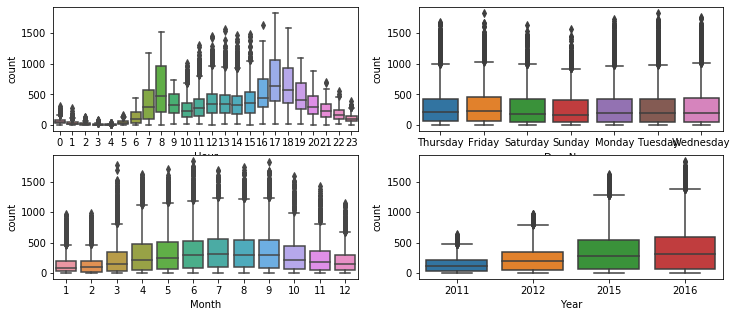

In [7]:
plt.figure(figsize = (12,5))
plt.subplot(2,2,1) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Hour'])
plt.subplot(2,2,2) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Day_Name'])
plt.subplot(2,2,3) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Month'])
plt.subplot(2,2,4) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['Year'])

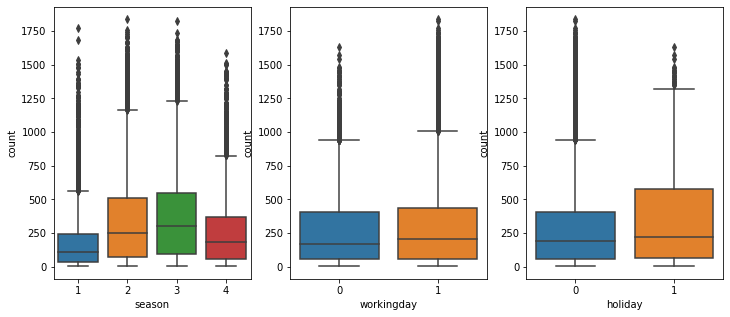

In [8]:
plt.figure(figsize = (12,5))
plt.subplot(1,3,1) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['season'])
plt.subplot(1,3,2) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['workingday'])
plt.subplot(1,3,3) # r, c, fignum
sns.boxplot(y = df_train['count'], x = df_train['holiday'])


## What have we learned? ##
- Hour can be binned in non-equal bin sizes to yield linearly ordered sums
- 'Day of the week' doesn't matter for total count of bikes
- Month has a slight polynomial 
- Year is linearly increasing on the mean (NOT in the median because of outliers)
- Season can also be modeled as polynomial
- Workday and holiday are redundant and can be tossed anyway

# Feature Engineering #

In [9]:
#Hour Binning
#hour_range = range(0,24)
#bins = ['Night']*4 + ['Morning']*5 + ['Day']*6 + ['Evening']*9
#hour_new = dict(zip(hour_range, bins))
#df_train['Hour_binned'] = df_train['Hour'].map(hour_new)

#Hour_Dict_Factorization_Low Level
#factor_hour = {'Night': 0, 'Morning':1, 'Day': 2, 'Evening': 3}
#df_train['Hour_Reconvert'] = df_train['Hour_binned'].map(factor_hour)

#df_train.groupby('Hour_Reconvert')['count'].count()

In [10]:
# Pre-fitting both categoricals with polynomials
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)
pipeline.fit(df_train[['Month']], df_train[['count']])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [11]:
pipeline.score(df_train[['Month']], df_train[['count']])

0.07138000917507448

## Month score jumped from .012 to .071 by poly fit degree 2

In [12]:
# Pre-fitting both categoricals with polynomials
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)
pipeline.fit(df_train[['season']], df_train[['count']])

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [13]:
pipeline.score(df_train[['season']], df_train[['count']])

0.06559995535131458

## Season score jumped from .012 to .065 by poly fit degree 2


In [14]:
df_train['Month_Poly2'] = df_train['Month']**2
df_train['season_Poly2'] = df_train['season']**2

In [15]:
df_train.columns

Index(['count', 'Hour', 'Day', 'Month', 'Year', 'atemp', 'humidity', 'temp',
       'windspeed', 'Day_Name', 'workingday', 'holiday', 'season',
       'Month_Poly2', 'season_Poly2'],
      dtype='object')

## Train Data Split to Cat and Num ## 

In [16]:
#Separate Categorical and Numerical Columns

num_list = ['count', 'atemp', 'humidity', 'temp', 'windspeed'] # Numeric All
num_nows = ['count', 'atemp', 'humidity', 'temp'] # Numeric No windspeed
cat_list = df_train.columns.drop(num_list).tolist() # Categorical but in fact has flattened numerics inside

## Numerical Data FE ##

In [17]:
df_train[num_list].head()

,count,atemp,humidity,temp,windspeed
2015-01-01 00:00:00-05:00,54,-4.02,67.0,-4.02,0.04
2015-01-01 01:00:00-05:00,114,-4.30,70.0,-4.30,0.43
2015-01-01 02:00:00-05:00,100,-4.09,67.0,-4.09,0.57
2015-01-01 03:00:00-05:00,16,-3.86,64.0,-3.86,0.55
2015-01-01 04:00:00-05:00,8,-4.27,64.0,-4.27,0.47


### Plot the distributions ###

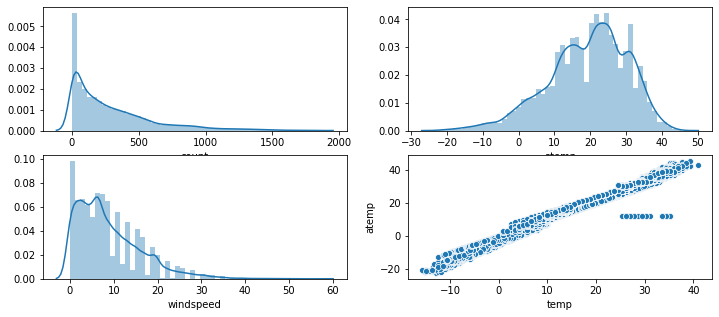

In [18]:
plt.figure(figsize = (12,5))
plt.subplot(2,2,1) # r, c, fignum
sns.distplot(df_train['count'])
plt.subplot(2,2,2) # r, c, fignum
sns.distplot(df_train['atemp'])
plt.subplot(2,2,3) # r, c, fignum
sns.distplot(df_train['windspeed'])
plt.subplot(2,2,4) # r, c, fignum
sns.scatterplot(x= df_train['temp'], y = df_train['atemp'])

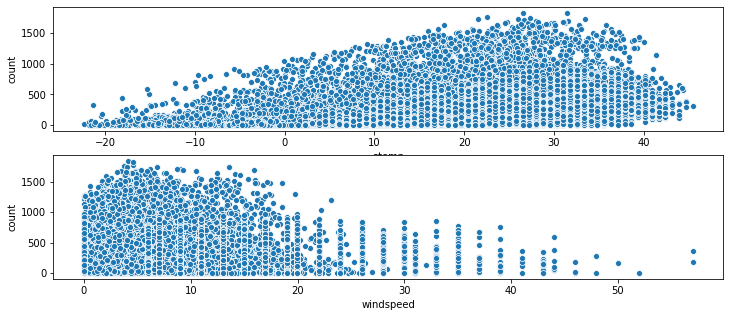

In [19]:
plt.figure(figsize = (12,5))
plt.subplot(2,1,1)
sns.scatterplot(x= df_train['atemp'], y = df_train['count'])
plt.subplot(2,1,2)
sns.scatterplot(x= df_train['windspeed'], y = df_train['count'])


### Toss the windspeed. Linearity will be hard to achieve ###

In [20]:
df_train.head()

,count,Hour,Day,Month,Year,atemp,humidity,temp,windspeed,Day_Name,workingday,holiday,season,Month_Poly2,season_Poly2
2015-01-01 00:00:00-05:00,54,0,1,1,2015,-4.02,67.0,-4.02,0.04,Thursday,1,0,1,1,1
2015-01-01 01:00:00-05:00,114,1,1,1,2015,-4.30,70.0,-4.30,0.43,Thursday,1,0,1,1,1
2015-01-01 02:00:00-05:00,100,2,1,1,2015,-4.09,67.0,-4.09,0.57,Thursday,1,0,1,1,1
2015-01-01 03:00:00-05:00,16,3,1,1,2015,-3.86,64.0,-3.86,0.55,Thursday,1,0,1,1,1
2015-01-01 04:00:00-05:00,8,4,1,1,2015,-4.27,64.0,-4.27,0.47,Thursday,1,0,1,1,1


## Decision on What Type of Scaling to Do: ##
- Since I inferred meanings from all variables on mean, (except hour and year), outliers are accounted for
- Moreover, I do not want to give up on the underlying distribution
- Chosen: MinMaxScaler(

In [21]:
Xtrain_nonscaled = df_train[['Hour','Year', 'atemp']]
ytrain_nonscaled = df_train['count']
ytrain_nonscaled

2015-01-01 00:00:00-05:00     54
2015-01-01 01:00:00-05:00    114
2015-01-01 02:00:00-05:00    100
2015-01-01 03:00:00-05:00     16
2015-01-01 04:00:00-05:00      8
2015-01-01 05:00:00-05:00      6
2015-01-01 06:00:00-05:00      7
2015-01-01 07:00:00-05:00     11
2015-01-01 08:00:00-05:00     32
2015-01-01 09:00:00-05:00     46
2015-01-01 10:00:00-05:00    103
2015-01-01 11:00:00-05:00    214
2015-01-01 12:00:00-05:00    202
2015-01-01 13:00:00-05:00    206
2015-01-01 14:00:00-05:00    231
2015-01-01 15:00:00-05:00    249
2015-01-01 16:00:00-05:00    285
2015-01-01 17:00:00-05:00    201
2015-01-01 18:00:00-05:00    149
2015-01-01 19:00:00-05:00     97
2015-01-01 20:00:00-05:00     90
2015-01-01 21:00:00-05:00     71
2015-01-01 22:00:00-05:00     54
2015-01-01 23:00:00-05:00     32
2015-01-02 00:00:00-05:00     25
2015-01-02 01:00:00-05:00     18
2015-01-02 02:00:00-05:00      8
2015-01-02 03:00:00-05:00      5
2015-01-02 04:00:00-05:00      5
2015-01-02 05:00:00-05:00     24
          

In [22]:
#Scale the Numerical Variables 
sc = MinMaxScaler()
Xtrain_sc= sc.fit_transform(Xtrain_nonscaled)
Xtrain_sc = pd.DataFrame(Xtrain_sc, columns = Xtrain_nonscaled.columns)



/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
ytrain_sc = np.log1p(ytrain_nonscaled)

In [24]:
#Scikit Linear Reg
m = LinearRegression()

In [25]:
m.fit(Xtrain_sc, ytrain_sc), m.score(Xtrain_sc, ytrain_sc)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False), 0.4361598919417635)

In [26]:
ypred = m.predict(Xtrain_sc)

mean_squared_log_error(ytrain_sc, ypred) #Scikit

0.05998254055856104

In [27]:
mean_squared_error(ytrain_sc, ypred) #Scikit

1.3251339328589182

In [28]:
m.coef_ , m.intercept_, Xtrain_sc.columns
#l = zip(Xtrain_sc.columns, m.coef_)
#fit_coeff = pd.DataFrame(l, columns = ['Variables', 'Coefficients'])
#fit_coeff.drop('Variables', axis = 1)

(array([2.59978777, 1.20691103, 2.99256645]),
 1.1377752561247148,
 Index(['Hour', 'Year', 'atemp'], dtype='object'))

In [29]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

1.296172776323972e-15


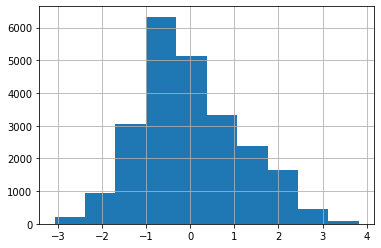

In [30]:
#Check the assumptions
#Mean residual is around zero
residuals = ypred - ytrain_sc
print(residuals.mean())
residuals.hist()


((array([-4.01742459, -3.80323536, -3.68611524, ...,  3.68611524,
          3.80323536,  4.01742459]),
  array([-3.08104657, -3.02790645, -2.95444896, ...,  3.78945534,
          3.81945822,  3.8260765 ])),
 (1.1413902215360625, 1.5877313072396556e-15, 0.9913631739431279))

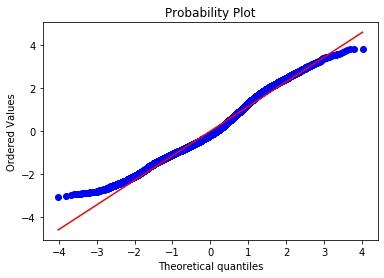

In [31]:
#Q-Q plot
probplot(residuals, plot=plt)


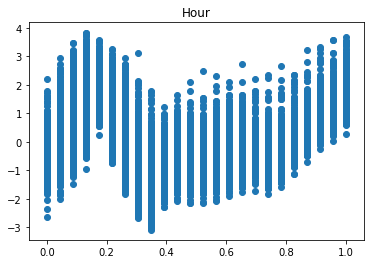

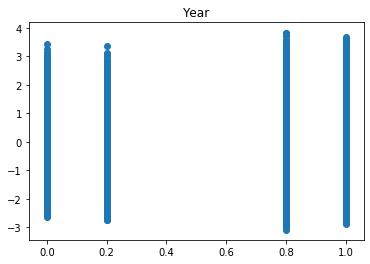

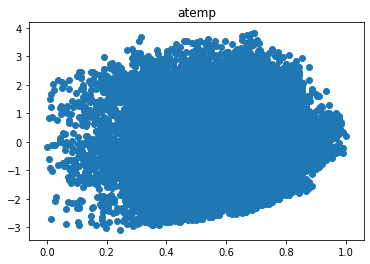

In [32]:
#Residuals uncorrelated with x and must be equally on and under 0

for column in Xtrain_sc.columns:
    plt.scatter(Xtrain_sc[column], residuals)
    plt.title(f'{column}')
    plt.show()